In [1]:
import os

from lvmdrp.utils.examples import get_frames_metadata

from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data", "data_simulator", "2d"))

# let's create the output directory
output_path = os.path.join("data")
os.makedirs(output_path, exist_ok=True)

# extract metadata
frames_table = get_frames_metadata(path=data_path)
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["imagetyp", "camera", "exptime"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: extracting metadata from 252 frames


100%|######################################################################################################| 252/252 [00:53<00:00,  4.67it/s]

[INFO]: successfully extracted metadata


In [3]:
fiberflats = frames_groups[(unique_groups["imagetyp"]=="fiberflat")&(unique_groups["camera"]=="b1")]
fiberflats

fiberflat_frame = fiberflats[0]
fiberflat_path = fiberflat_frame["path"]
fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]

601 Fibers found


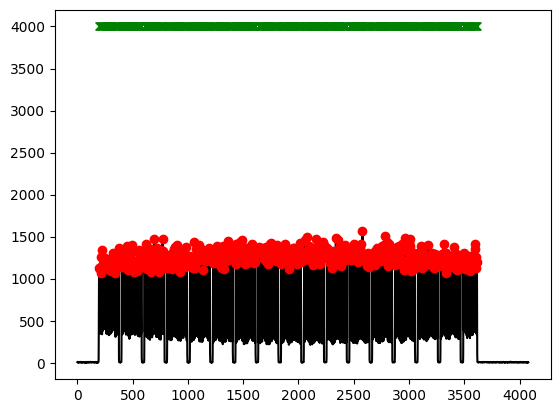

In [4]:
imageMethod.findPeaksAuto_drp(
    in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    out_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
    nfibers=601, slice=3000, threshold=100, method="hyperbolic", median_box=0, median_cross=0, verbose=True
)

In [5]:
imageMethod.tracePeaks_drp(
    in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    out_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    in_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-{fiberflat_expnum}.txt"),
    steps=50, coadd=50, threshold_peak=500, max_diff=2, method="hyperbolic", median_box=0, median_cross=0, verbose=True
)

In [8]:
imageMethod.subtractStraylight_drp(
    in_image=os.path.join(output_path, f"lvm-cfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    out_image=os.path.join(output_path, f"lvm-sfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    out_stray=os.path.join(output_path, f"lvm-stray-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    in_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    aperture=4, poly_cross=2, smooth_disp=0, smooth_gauss=30
)

In [13]:
imageMethod.extractSpec_drp(
    in_image=os.path.join(output_path, f"lvm-sfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    out_rss=os.path.join(output_path, f"lvm-xfiberflat-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    in_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-{fiberflat_expnum}.fits"),
    method="aperture", aperture=4, plot=1, parallel="auto"
)